**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential



**Load the Dataset**

In [2]:
# Load the data
train_df = pd.read_csv('/content/labeled_final_train.csv')
val_df = pd.read_csv('/content/labeled_final_validation.csv')
test_df = pd.read_csv('/content/labeled_final_test.csv')

**Prepare the Dataset**

In [3]:
# Combine the sentence pairs

train_texts = train_df['sentence1'] + " [SEP] " + train_df['sentence2']
val_texts = val_df['sentence1'] + " [SEP] " + val_df['sentence2']
test_texts = test_df['sentence1'] + " [SEP] " + test_df['sentence2']

all_texts = pd.concat([train_texts, val_texts, test_texts])


**Tokenization**

In [4]:
# Tokenize texts
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(all_texts)

# Convert the texts in the train, validation, and test sets
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


**Sequence Padding**

In [5]:
max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in val_sequences), max(len(seq) for seq in test_sequences))

# Pad the sequences so that they all have the same length.
train_data = pad_sequences(train_sequences, maxlen=max_length)
val_data = pad_sequences(val_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)

**Label Preparation**

In [6]:
#Extract labels from the dataframes
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

**Defining the CNN Model**

In [7]:
vocab_size = len(tokenizer.word_index) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),  # Increased embedding dimensions
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dropout(0.5),  # Another dropout layer
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 100)           3607700   
                                                                 
 conv1d (Conv1D)             (None, 59, 128)           64128     
                                                                 
 dropout (Dropout)           (None, 59, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 57, 64)            24640     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                650       
                                                        

**Train and Evaluate the Model**

In [8]:
# Train the model
history = model.fit(train_data, train_labels, batch_size=32, epochs=3, validation_data=(val_data, val_labels))

# Evaluate the model
val_loss, val_acc = model.evaluate(val_data, val_labels)
print(f'Validation Accuracy: {val_acc}')

test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_acc}')


Epoch 1/3
1544/1544 [==============================] - 168s 108ms/step - loss: 0.6872 - accuracy: 0.5576 - val_loss: 0.6856 - val_accuracy: 0.5576
Epoch 2/3
1544/1544 [==============================] - 168s 109ms/step - loss: 0.6853 - accuracy: 0.5579 - val_loss: 0.6851 - val_accuracy: 0.5576
Epoch 3/3
250/250 [==============================] - 2s 9ms/step - loss: 0.6834 - accuracy: 0.5629
Validation Accuracy: 0.562874972820282
250/250 [==============================] - 3s 11ms/step - loss: 0.6832 - accuracy: 0.5635
Test Accuracy: 0.5634999871253967


**Predicting Paraphrase**

In [9]:
def predict_paraphrase(sentence1, sentence2):
    combined_text = sentence1 + " [SEP] " + sentence2
    sequence = tokenizer.texts_to_sequences([combined_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded_sequence)
    return "Paraphrase" if prediction[0][0] > 0.5 else "Not Paraphrase"


In [10]:
sentence1 = "The quick brown fox jumps over the lazy dog."
sentence2 = "A fast, dark-colored fox leaps above a slow-moving dog."
print(predict_paraphrase(sentence1, sentence2))

1/1 [==============================] - 0s 142ms/step
Not Paraphrase


In [11]:
sentence3 = "My name is Sam and I am a good boy."
sentence4 = "I'm Sam and I consider myself to be a well-behaved young man.."
print(predict_paraphrase(sentence3, sentence4))

1/1 [==============================] - 0s 26ms/step
Not Paraphrase


In [12]:
sentence5 = "BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labeling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts. More precisely, it was pretrained with two objectives:"
sentence6 = "BERT is a transformer-based model that was pre-trained using a vast collection of English text in a self-supervised manner. This entails that it underwent pre-training solely on raw texts without any human-annotated labels, allowing it to leverage a vast array of publicly accessible data through an automated process that creates inputs and labels directly from the texts. Specifically, it was designed with two primary pre-training objectives."
print(predict_paraphrase(sentence5, sentence6))

1/1 [==============================] - 0s 27ms/step
Not Paraphrase


In [13]:
sentence7 = "The conclusion that explicit part descriptions enhance abstract reasoning in both humans and models is well-supported by the data."
sentence8 = "The data strongly supports the idea that detailed descriptions of parts improve abstract reasoning in both humans and computational models."
print(predict_paraphrase(sentence7, sentence8))

1/1 [==============================] - 0s 22ms/step
Not Paraphrase


**Plotting Training and Validation Accuracy**

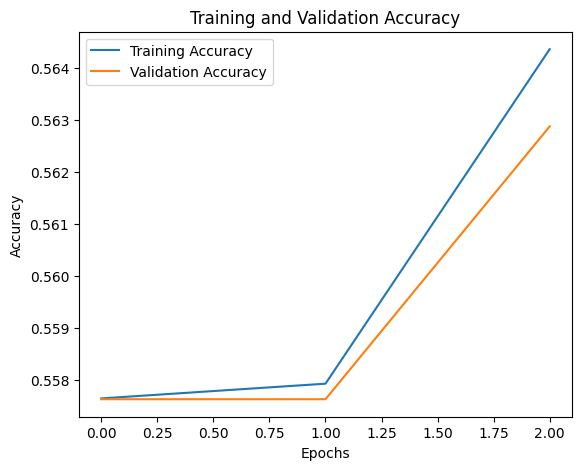

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


**Plotting Training and Validation Loss**

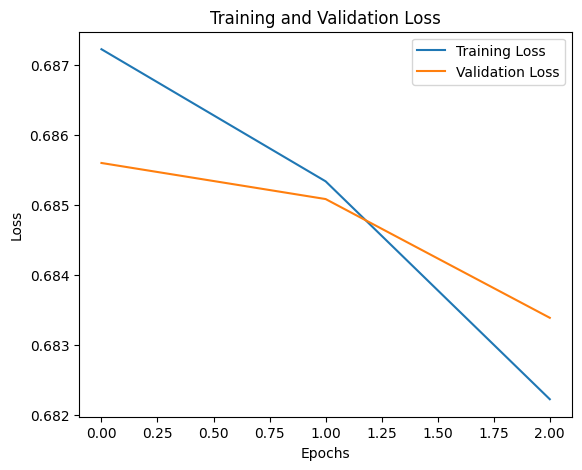

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Generate the confusion matrix**

In [19]:
# Calculate predictions
val_pred = model.predict(val_data).flatten()
val_pred_classes = (val_pred > 0.5).astype(int)


250/250 [==============================] - 3s 11ms/step


In [20]:
val_true = val_labels

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

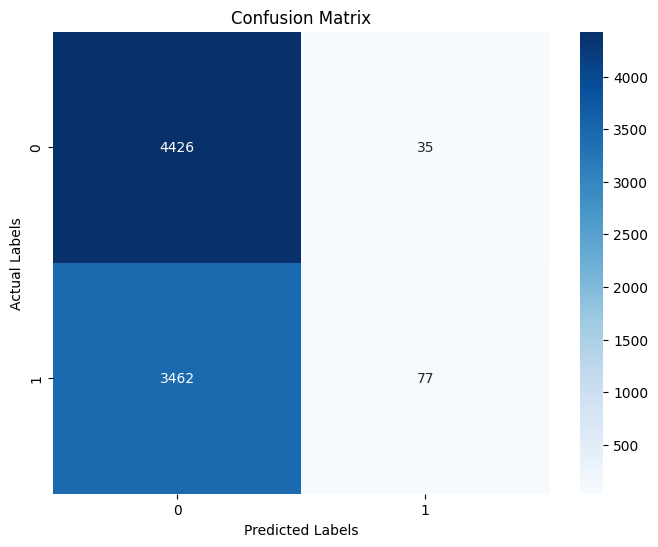

In [23]:
# Confusion Matrix
cm = confusion_matrix(val_true, val_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


**Compute ROC curve and ROC area**

In [25]:
fpr, tpr, thresholds = roc_curve(val_true, val_pred)
roc_auc = auc(fpr, tpr)


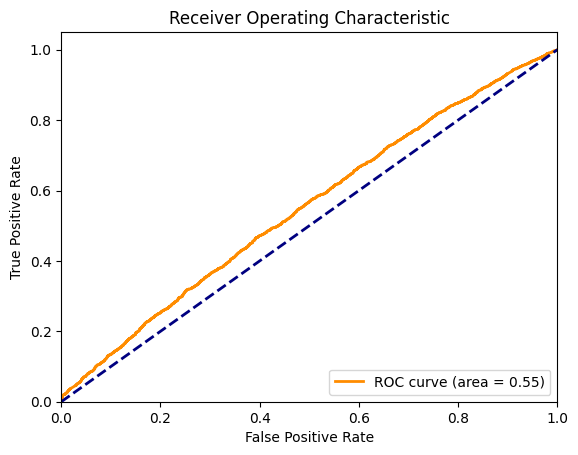

In [26]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**Classification Report**

In [27]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(val_true, val_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.56      0.99      0.72      4461
           1       0.69      0.02      0.04      3539

    accuracy                           0.56      8000
   macro avg       0.62      0.51      0.38      8000
weighted avg       0.62      0.56      0.42      8000

